<a href="https://colab.research.google.com/github/Tsung-Hung/dummy-git/blob/master/Colorloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
import numpy as np
import sys
from datetime import datetime
from tqdm import tqdm
from PIL import Image
import imageio

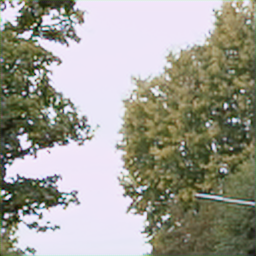

In [92]:
enhanced = Image.open('/content/23790_20230221_microisp')
enhanced

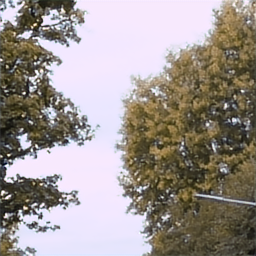

In [93]:
#enhanced = Image.open('/content/23790_20230308_jmu_lr0.001')
enhanced = Image.open('/content/23790_20230217_epoch2000')
enhanced

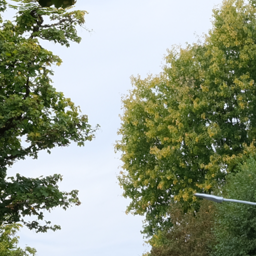

In [94]:
enhanced = Image.open('/content/23790_GT')
enhanced

In [165]:
enhanced_good = Image.open('/content/23790_20230221_microisp')
enhanced_good = np.float32(np.reshape(enhanced_good, [1, 256, 256, 3])) / 255

enhanced_bad = Image.open('/content/23790_20230217_epoch2000')
enhanced_bad = np.float32(np.reshape(enhanced_bad, [1, 256, 256, 3])) / 255

dslr = Image.open('/content/23790_GT')
dslr = np.float32(np.reshape(dslr, [1, 256, 256, 3])) / 255

In [166]:
#SSIM
print('------SSIM------')
dslr_gray = tf.image.rgb_to_grayscale(dslr)
enhanced_gray = tf.image.rgb_to_grayscale(enhanced_good)
loss_ssim = tf.image.ssim(enhanced_gray, dslr_gray, 1.0)
print('mircoisp : ',loss_ssim)

enhanced_gray = tf.image.rgb_to_grayscale(enhanced_bad)
loss_ssim = tf.image.ssim(enhanced_gray, dslr_gray, 1.0)
print('jmu : ',loss_ssim)


## PSNR loss
print('------PSNR------')
loss_psnr = tf.reduce_mean(tf.image.psnr(enhanced_good, dslr, 1.0))
print('mircoisp : ',loss_psnr)

loss_psnr = tf.reduce_mean(tf.image.psnr(enhanced_bad, dslr, 1.0))
print('jmu : ',loss_psnr)

------SSIM------
mircoisp :  tf.Tensor([0.8161089], shape=(1,), dtype=float32)
jmu :  tf.Tensor([0.8824944], shape=(1,), dtype=float32)
------PSNR------
mircoisp :  tf.Tensor(19.710245, shape=(), dtype=float32)
jmu :  tf.Tensor(21.547617, shape=(), dtype=float32)


In [170]:
## UV loss
import scipy.stats as st
def gauss_kernel(kernlen=21, nsig=3, channels=1):
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    out_filter = np.array(kernel, dtype = np.float32)
    out_filter = out_filter.reshape((kernlen, kernlen, 1, 1))
    out_filter = np.repeat(out_filter, channels, axis = 2)
    return out_filter

def blur(x):
    kernel_var = gauss_kernel(21, 3, 3)
    return tf.nn.depthwise_conv2d(x, kernel_var, [1, 1, 1, 1], padding='SAME')


dslr_yuv = tf.image.rgb_to_yuv(dslr)
enhanced_lab = tf.image.rgb_to_yuv(enhanced_good)
enhanced_uv_blur = blur(enhanced_lab)[..., -2:]
dslr_uv_blur = blur(dslr_yuv)[..., -2:]
loss_uv = tf.reduce_mean(tf.abs(tf.math.subtract(dslr_uv_blur, enhanced_uv_blur)))
print('mircoisp : ',loss_uv)

enhanced_lab = tf.image.rgb_to_yuv(enhanced_bad)
enhanced_uv_blur = blur(enhanced_lab)[..., -2:]
dslr_uv_blur = blur(dslr_yuv)[..., -2:]
loss_uv = tf.reduce_mean(tf.abs(tf.math.subtract(dslr_uv_blur, enhanced_uv_blur)))
print('jmu : ',loss_uv)

mircoisp :  tf.Tensor(0.016895374, shape=(), dtype=float32)
jmu :  tf.Tensor(0.026471334, shape=(), dtype=float32)


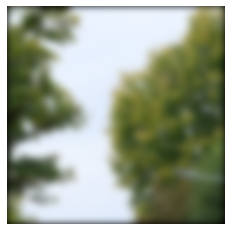

In [171]:
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage import color

# Convert the tensor to a NumPy array and transpose the axes
dslr_yuv_blur = blur(dslr_yuv)
dslr_yuv_blur_np = dslr_yuv_blur.numpy().squeeze()

# Convert the YUV image to RGB
dslr_yuv_blur_rgb = color.yuv2rgb(dslr_yuv_blur_np)

# Plot the RGB image
plt.imshow(dslr_yuv_blur_rgb)
plt.axis('off')
plt.show()

#Pytorch

In [139]:
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.nn as nn
import math
import torch

enhanced_good = Image.open('/content/23790_20230221_microisp').convert('RGB')
enhanced_good = TF.to_tensor(enhanced_good)
enhanced_good = enhanced_good.reshape(1,3,256,256)

enhanced_bad = Image.open('/content/23790_20230217_epoch2000').convert('RGB')
enhanced_bad = TF.to_tensor(enhanced_bad)
enhanced_bad = enhanced_bad.reshape(1,3,256,256)

dslr = Image.open('/content/23790_GT').convert('RGB')
dslr = TF.to_tensor(dslr)
dslr = dslr.reshape(1,3,256,256)

In [158]:
def rgb_yuv(RGB):
    Y= 0.2990*RGB[:,0,:,:] + 0.5870*RGB[:,1,:,:] + 0.1140*RGB[:,2,:,:]
    Y=Y.reshape(Y.shape[0],1,Y.shape[1],Y.shape[2])

    U= -0.14714119*RGB[:,0,:,:] -0.28886916*RGB[:,1,:,:] + 0.43601035*RGB[:,2,:,:]
    U=U.reshape(U.shape[0],1,U.shape[1],U.shape[2])

    V= 0.61497538*RGB[:,0,:,:] -0.51496512*RGB[:,1,:,:] - 0.10001026*RGB[:,2,:,:]
    V=V.reshape(V.shape[0],1,V.shape[1],V.shape[2])

    return torch.cat([Y,U,V],1)


def gauss_kernel(kernlen=21, nsig=3, channels=1):
    interval = (2 * nsig + 1.) / (kernlen)
    x = np.linspace(-nsig - interval / 2., nsig + interval / 2., kernlen + 1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw / kernel_raw.sum()
    out_filter = np.array(kernel, dtype=np.float32)
    out_filter = out_filter.reshape((kernlen, kernlen, 1, 1))
    out_filter = np.repeat(out_filter, channels, axis=2)
    return out_filter


class Blur(nn.Module):
    def __init__(self, nc):
        super(Blur, self).__init__()
        self.nc = nc
        kernel = gauss_kernel(kernlen=21, nsig=3, channels=self.nc)
        kernel = torch.from_numpy(kernel).permute(2, 3, 0, 1)
        self.weight = nn.Parameter(data=kernel, requires_grad=False)

    def forward(self, x):
        if x.size(1) != self.nc:
            raise RuntimeError(
                "The channel of input [%d] does not match the preset channel [%d]" % (x.size(1), self.nc))
        x = F.conv2d(x, self.weight, stride=1, padding=10, groups=self.nc)
        return x

class ColorLoss(nn.Module):
    def __init__(self):
        super(ColorLoss, self).__init__()

    def forward(self, x1, x2):
        #return torch.sum(torch.pow((x1 - x2), 2)).div(2 * x1.size()[0])
        return torch.mean(torch.abs(x1 - x2))

cl = ColorLoss()
blur_rgb = Blur(3)

dslr_yuv = rgb_yuv(dslr)
dslr_uv_blur = blur_rgb(dslr_yuv)[:,1:3,:,:]

enhanced_good_lab = rgb_yuv(enhanced_good)
enhanced_good_uv_blur = blur_rgb(enhanced_good_lab)[:,1:3,:,:]

enhanced_bad_lab = rgb_yuv(enhanced_bad)
enhanced_bad_uv_blur = blur(enhanced_bad_lab)[:,1:3,:,:]

loss_uv = cl(dslr_uv_blur, enhanced_good_uv_blur)
print('micro : ',loss_uv)

loss_uv = cl(dslr_uv_blur, enhanced_bad_uv_blur)
print('jmu : ',loss_uv)

micro :  tensor(0.0169)
jmu :  tensor(0.0268)


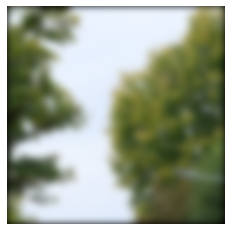

In [163]:
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage import color

# Convert the tensor to a NumPy array and transpose the axes
dslr_yuv_blur = blur_rgb(dslr_yuv)
dslr_yuv_blur_np = dslr_yuv_blur.numpy().squeeze().transpose(1, 2, 0)

# Convert the YUV image to RGB
dslr_yuv_blur_rgb = color.yuv2rgb(dslr_yuv_blur_np)

# Plot the RGB image
plt.imshow(dslr_yuv_blur_rgb)
plt.axis('off')
plt.show()

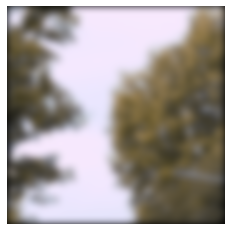

In [164]:
# Convert the tensor to a NumPy array and transpose the axes
enhanced_good_yuv_blur = blur_rgb(enhanced_bad_lab)
enhanced_good_yuv_blur_np = enhanced_good_yuv_blur.numpy().squeeze().transpose(1, 2, 0)

# Convert the YUV image to RGB
enhanced_good_yuv_blur_rgb = color.yuv2rgb(enhanced_good_yuv_blur_np)

# Plot the RGB image
plt.imshow(enhanced_good_yuv_blur_rgb)
plt.axis('off')
plt.show()